In [1]:
import numpy as np
import random 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os 

from regression_utils import *
from sklearn.metrics import mean_squared_error

np.set_printoptions(suppress=True)
%matplotlib inline

In [2]:
# convention followed in relation to scikit documentation 
# y = countryQuantity 
# y1 = countryQuantityTrain
# Y = countryQuantityTest
# y_pred = countryQuantityPredict

# X = countryQuantity2 
# X1 = countryQuantity2Train
# x_mis = countryQuantity2Test
# x = countryQuantity2Predict

# c = combinedZip

In [3]:
#reading data from csv 
df = pd.read_csv('datasets_12603_17232_Life Expectancy Data.csv')
df.fillna(df.mean(), inplace=True)

# change here 
country = 'Germany'

# extract dataframe for selected country
%store -r countryDataFrame

# Feature 1 
countryQuantity = 'life_expectancy'

#np.random.seed(5)
split = np.random.randint(1,10)/10
print('Train:Test split is: ', split, ':',round(1-split,1))
# train test split
randomRowsTrain = countryDataFrame.sample(frac=split)
randomRowsTest = countryDataFrame.loc[~countryDataFrame.index.isin(randomRowsTrain.index)]

# train test split row numbers (to keep record of train test split in order to aid plotting)
rowTrain = list(randomRowsTrain['year'].get_values())
rowTest = list(randomRowsTest['year'].get_values())

# extract data (countryQuantity) from dataframe depending on the train test split 
countryQuantityTrain = columnExtractor(randomRowsTrain, countryQuantity)
countryQuantityTest = columnExtractor(randomRowsTest, countryQuantity)

# extract data (allFeatures) from dataframe depending on the train test split 
desiredFeatures = ['adult_mortality', 
                   'infant_deaths', 
                   'alcohol',
                   #'percentage_expenditure',
                   'hepatitis_b',
                   #'measles',
                   #'bmi',
                   'under-five_deaths',
                   'polio',
                   #'total_expenditure', 
                   'diphtheria',
                   'hiv/aids',
                   #'gdp',
                   #'population',
                   'thinness_10-19_years',
                   'thinness_5-9_years',
                   'income_composition_of_resources',
                   'schooling',
                   'year']

allFeaturesTrain = variableColumnExtractor(randomRowsTrain, desiredFeatures)
allFeaturesTest = variableColumnExtractor(randomRowsTest, desiredFeatures)

Train:Test split is:  0.4 : 0.6


lengthscale is: 
 34
Train data: 
       adult_mortality  infant_deaths  alcohol  hepatitis_b  under-five_deaths  \
1004             85.0              3    11.67          9.0                  3   
1001              8.0              2    11.36         87.0                  3   
1009             95.0              3    12.91         84.0                  4   
996              71.0              2    10.94         88.0                  3   
1002             82.0              3    11.50         86.0                  3   
1006              9.0              3    11.92          9.0                  4   

      polio  diphtheria  hiv/aids  thinness_10-19_years  thinness_5-9_years  \
1004   95.0        96.0       0.1                   1.1                 1.1   
1001   95.0        96.0       0.1                   1.1                 1.1   
1009   94.0         9.0       0.1                   1.2                 1.2   
996    94.0        95.0       0.1                   1.1                 1.1   
10

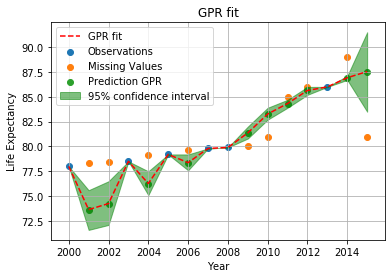

In [4]:
##Gaussian regression analysis 
lengthScale = np.random.randint(1, 50) 
print('lengthscale is: \n',lengthScale)

print('Train data: \n', allFeaturesTrain)



kernel = C(1.0, (1e-3, 1e3)) * RBF(lengthScale, (1e-2, 1e2))

#define kernel 
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

#fit data 
gp.fit(allFeaturesTrain, countryQuantityTrain)

#predict 
countryQuantityPredict, sigma = gp.predict(allFeaturesTest, return_std=True)

predictValGPR = list(zip(rowTest, list(countryQuantityPredict), list(sigma)))
predictValGPR.sort()
#print(predictValGPR)

trainVal = list(zip(rowTrain, list(countryQuantityTrain)))
trainVal.sort()
#print(trainVal)

valGPR = trainVal + predictValGPR
valGPR.sort(key = lambda x: x[0])


year, age = zip(*valGPR)
#print(age)   #final life expectancy distribution 
#print(valGPR)

countryQuantity2, GPR = zip(*valGPR)

#visualize output 
plt.plot(countryQuantity2, GPR,'--',color='r',label='GPR fit')
plt.scatter(rowTrain,countryQuantityTrain,label='Observations')
plt.scatter(rowTest,countryQuantityTest,label='Missing Values')
plt.scatter(rowTest,countryQuantityPredict,label='Prediction GPR') 

#processing for plotting the envelope (variance 0 at points where data is available 
#equal to 2*sigma at other points)
countryQuantityPredict = countryQuantityPredict[::-1] 
sigma = sigma[::-1]

test_list = rowTest

orderedSigma = list() 
counter = 0

for x in range(2000,2016): 
    if x in test_list: 
        orderedSigma.append(predictValGPR[counter][2])
        counter += 1
    else : 
        orderedSigma.append(0)
    
        
sigma = [round(elem, 1) for elem in sigma]
#print(orderedSigma)
orderedSigma = [round(elem, 1) for elem in orderedSigma]
orderedSigma = [2*x for x in orderedSigma]
#print(orderedSigma)

age = [round(elem, 1) for elem in age]
age = np.asarray(age)


orderedSigma = np.asarray(orderedSigma)


positive = age + orderedSigma
negative = age - orderedSigma


plt.fill_between(np.linspace(np.min(countryDataFrame['year'].values),
                             np.max(countryDataFrame['year'].values),
                             16), 
                     positive, 
                     (negative), 
                     color='green',alpha=0.5,label='95% confidence interval')
plt.ylabel('Life Expectancy')
plt.title('GPR fit')
plt.grid()
plt.xlabel('Year')
plt.legend()
#plt.show()

#plt.savefig('GPR output for features = %s'%(desiredFeatures), dpi=300)

#only for those columns which have / in their name example (hiv/aids)
plt.savefig('GPR output for all 13 features', dpi=300)

Train data: 
       adult_mortality  infant_deaths  alcohol  hepatitis_b  under-five_deaths  \
1004             85.0              3    11.67          9.0                  3   
1001              8.0              2    11.36         87.0                  3   
1009             95.0              3    12.91         84.0                  4   
996              71.0              2    10.94         88.0                  3   
1002             82.0              3    11.50         86.0                  3   
1006              9.0              3    11.92          9.0                  4   

      polio  diphtheria  hiv/aids  thinness_10-19_years  thinness_5-9_years  \
1004   95.0        96.0       0.1                   1.1                 1.1   
1001   95.0        96.0       0.1                   1.1                 1.1   
1009   94.0         9.0       0.1                   1.2                 1.2   
996    94.0        95.0       0.1                   1.1                 1.1   
1002   95.0        96.0

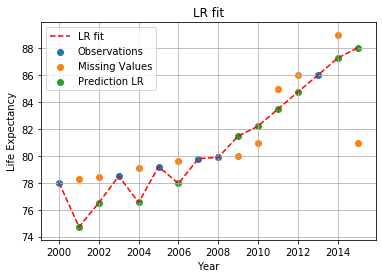

In [5]:
#Linear regression analysis 
regr = linear_model.LinearRegression()
print('Train data: \n', allFeaturesTrain)

regr.fit(allFeaturesTrain, countryQuantityTrain)

countryQuantityPredictLR = regr.predict(allFeaturesTest)

predictValLR = list(zip(rowTest, list(countryQuantityPredictLR)))
predictValLR.sort()

valLR = trainVal + predictValLR
valLR.sort(key = lambda x: x[0]) 

years, LR = zip(*valLR)

plt.plot(years, LR,'--',color='r',label='LR fit')
plt.scatter(rowTrain,countryQuantityTrain,label='Observations')
plt.scatter(rowTest,countryQuantityTest,label='Missing Values')
plt.scatter(rowTest,countryQuantityPredictLR,label='Prediction LR')
plt.grid()
plt.xlabel('Year')
plt.title('LR fit')
plt.ylabel('Life Expectancy')
plt.legend()
#plt.show()

#plt.savefig('LR output for features = %s'%(desiredFeatures), dpi=300)

##only for those columns which have / in their name example (hiv/aids)
plt.savefig('LR output for all 13 features', dpi=300)

In [6]:
# error computation for GPR 
groundTruth = countryDataFrame[countryQuantity].get_values()[::-1]
print('groundTruth values \n',groundTruth)

print('------------------------------------------')

GPR = [round(float(i),1) for i in list(GPR)]
print('GPR prediction \n',GPR)

print('------------------------------------------')

errorGPR = np.sqrt(mean_squared_error(groundTruth, GPR))

# error computation for LR 
LR = [round(float(i),1) for i in list(LR)]
print('LR prediction \n',LR) 

errorLR = np.sqrt(mean_squared_error(groundTruth, LR))
print('GPR error \n',errorGPR, '%')
print('LR error \n',errorLR, '%')

#go with rmse for outliers 
#try using normalization

groundTruth values 
 [78.  78.3 78.4 78.5 79.1 79.2 79.6 79.8 79.9 80.  81.  85.  86.  86.
 89.  81. ]
------------------------------------------
GPR prediction 
 [78.0, 73.6, 74.3, 78.5, 76.3, 79.2, 78.4, 79.8, 79.9, 81.4, 83.3, 84.3, 85.6, 86.0, 86.9, 87.5]
------------------------------------------
LR prediction 
 [78.0, 74.7, 76.5, 78.5, 76.5, 79.2, 78.0, 79.8, 79.9, 81.5, 82.2, 83.5, 84.8, 86.0, 87.3, 88.0]
GPR error 
 2.534018547682712 %
LR error 
 2.307054399011865 %


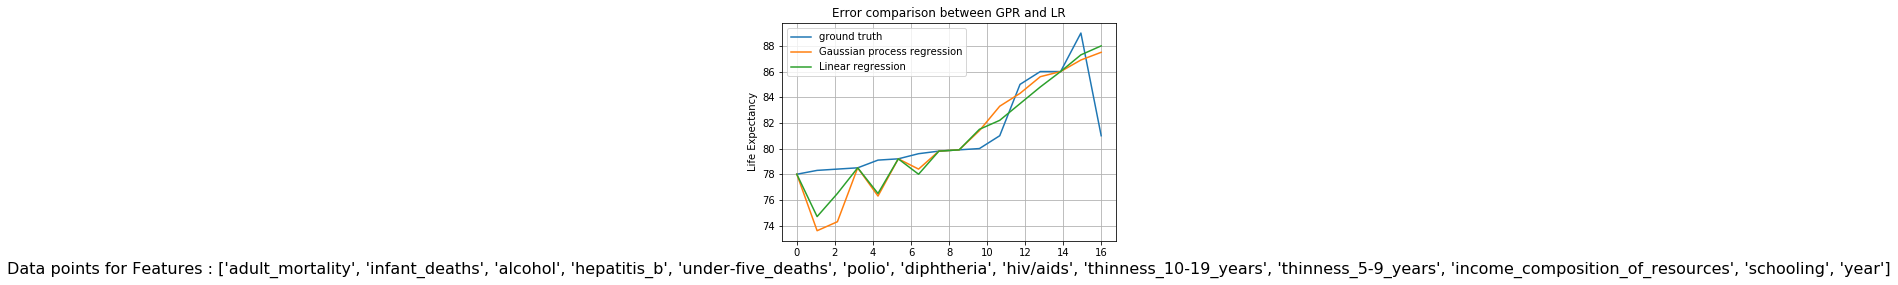

In [7]:
#comparing lr, gpr and groundtruth 

plt.ylabel('Life Expectancy')
plt.xlabel('Data points for Features : %s'%(desiredFeatures),fontsize=16)
plt.plot(np.linspace(0,16,16), groundTruth, label='ground truth')
plt.plot(np.linspace(0,16,16), GPR, label = 'Gaussian process regression')
plt.plot(np.linspace(0,16,16), LR, label = 'Linear regression')
plt.title('Error comparison between GPR and LR')
plt.legend()
plt.grid()

#plt.savefig('Error analysis for features = %s'%(desiredFeatures), dpi=300)

##only for those columns which have / in their name example (hiv/aids)
plt.savefig('Error analysis for all 13 features', dpi=300)


### Conclusion 


### References 

Lecture Notes and slides <br> 
https://yugeten.github.io/posts/2019/09/GP/           <br> 
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html    <br>
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-download-auto-examples-gaussian-process-plot-gpr-co2-py    <br> 
https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/tutorial/statistical_inference/supervised_learning.html